In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
import torchvision.transforms.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as tx
from torchvision.transforms import GaussianBlur
# from hybrid_model_v1 import HybridSegModel
from hybrid_model_v2 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):

    p = 0.5
    
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness=0.5)
    #     image = jitter(image)
    # if(random.random() < p):
    #     angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
    #     translate = (random.uniform(-0.05, 0.05) * image.size[0],
    #                  random.uniform(-0.05, 0.05) * image.size[1])  # 最多平移 ±5%
    #     scale = random.uniform(0.95, 1.05)  # 尺度縮放 ±5%
    #     shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
    
    #     image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
    #     mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)
    # if random.random() < p:
    #     image = F.hflip(image)
    #     mask = F.hflip(mask)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor

    
train_dataset = Thyroid_Dataset("train_v2.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = Thyroid_Dataset("test_v2.csv", transform = test_augmentation, image_size = image_size, return_from_dataset = True, crop_DDTI = True, histo_match = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

image, mask, seg_type = next(iter(train_dataloader))
image = image
mask = mask

In [5]:
print("std : ", torch.std(image))
print("unique : ", torch.unique(mask))

std :  tensor(1.0000)
unique :  tensor([0., 1.])


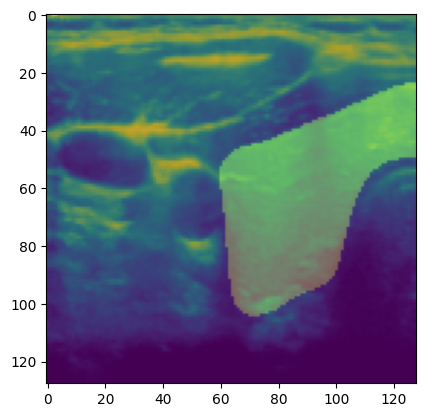

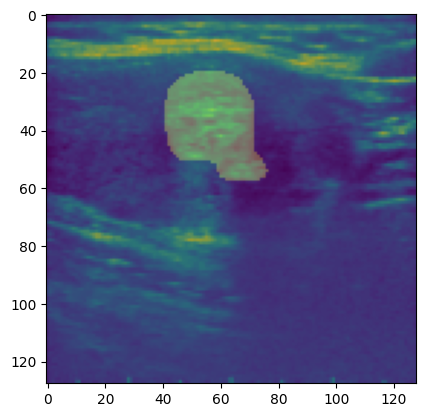

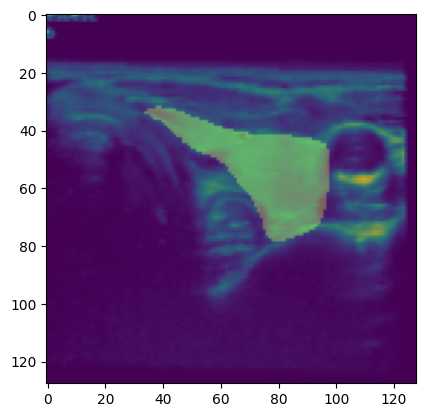

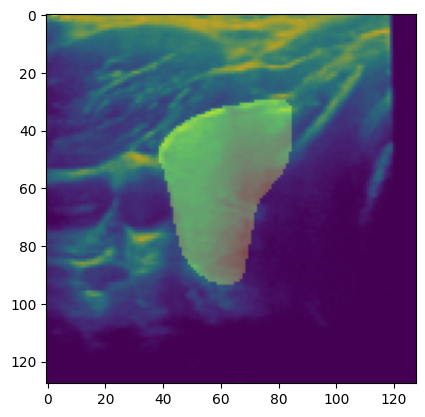

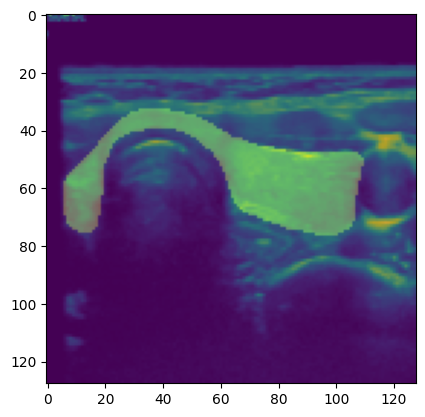

In [6]:
index = 39
for index in range(5):
    # plt.subplot(1,2,1)
    # plt.imshow(mask[index][0], alpha = 0.3)
    plt.imshow(image[index][0])
    plt.imshow(mask[index][0], alpha = 0.3)
    
    # plt.subplot(1,2,2)
    # plt.imshow(mask[index][0])
    plt.show()

In [7]:
# model = Eff_Unet(
#         layers=[5, 5, 15, 10],
#         embed_dims=[40, 80, 192, 384],
#         downsamples=[True, True, True, True],
#         vit_num=6,
#         drop_path_rate=0.1,
#         num_classes=1,
#         resolution = image_size).cuda()
# model = HarDMSEG(in_channels = 1)
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = PMFSNet_FFT(in_channels = 1, out_channels = 2, dim = "2d")
# model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)

In [8]:
# loss_fn_nodule = StructureLoss()
# loss_fn_gland = StructureLoss()

In [9]:
# model.to("cuda")
# image = image.to("cuda")
# mask = mask.to("cuda")

In [10]:
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# for epoch in range(1000):
#     outputs = model(image)

#     nodule_output = outputs[:, 0:1, :, :][seg_type==1]
#     nodule_mask = mask[seg_type==1]
    
#     gland_output = outputs[:, 1:2, :, :][seg_type==2]
#     gland_mask = mask[seg_type==2]
#     # outputs = torch.sigmoid(logits)
#     # print(nodule_output.shape, nodule_mask.shape)
#     nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
#     gland_loss = loss_fn_gland(gland_output, gland_mask)
    
#     loss = nodule_loss + gland_loss
    
#     IOU = (IOU_score(nodule_output, nodule_mask) + IOU_score(gland_output, gland_mask)) / 2
    
#     dice_loss = DiceLoss()
#     # print(dice_loss(nodule_output, nodule_mask))
#     # print(dice_loss(gland_output, gland_mask)) 
#     DICE = ((1 - dice_loss(nodule_output, nodule_mask)) + (1 - dice_loss(gland_output, gland_mask))) / 2
    
#     # Backward and optimize
#     optimizer.zero_grad()   # clear previous gradients
#     loss.backward()         # compute gradients
#     optimizer.step()        # update weights

#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, IOU: {IOU.item():.4f}, DICE: {DICE.item()}")

In [12]:
# (1 - dice_loss(nodule_output, nodule_mask))

In [13]:
# index = 4
# plt.subplot(1,2,1)
# plt.imshow(nodule_mask[index][0].detach().cpu().numpy())
# nodule_output = (nodule_output > 0.5)
# plt.subplot(1,2,2)
# plt.imshow(nodule_output[index][0].detach().cpu().numpy())

In [14]:
# index = 4
# plt.subplot(1,2,1)
# plt.imshow(gland_mask[index][0].detach().cpu().numpy())
# gland_output = (gland_output > 0.5)
# plt.subplot(1,2,2)
# plt.imshow(gland_output[index][0].detach().cpu().numpy())

In [15]:
def train(dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, seg_type in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)

        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]
        
        gland_output = outputs[:, 1:2, :, :][seg_type==2]
        gland_mask = mask[seg_type==2]

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
        gland_loss = loss_fn_gland(gland_output, gland_mask)


        
        loss = nodule_loss + gland_loss
        IOU = (IOU_score(nodule_output, nodule_mask) + IOU_score(gland_output, gland_mask)) / 2

        dice_loss = DiceLoss()
        DICE = ((1 - dice_loss(nodule_output, nodule_mask)) + (1 - dice_loss(gland_output, gland_mask))) / 2

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    DDTI_total_loss = 0
    TN3K_total_loss = 0
    
    total_IOU = 0
    DDTI_total_IOU = 0
    TN3K_total_IOU = 0
    
    total_DICE = 0
    DDTI_total_DICE = 0
    TN3K_total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, seg_type, from_dataset in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]


        DDTI_nodule_output = nodule_output[from_dataset==1]
        TN3K_nodule_output = nodule_output[from_dataset==3]

        DDTI_nodule_mask = nodule_mask[from_dataset==1]
        TN3K_nodule_mask = nodule_mask[from_dataset==3]
        

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
        DDTI_nodule_loss = loss_fn_nodule(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_nodule_loss = loss_fn_nodule(TN3K_nodule_output, TN3K_nodule_mask)
        
        IOU = IOU_score(nodule_output, nodule_mask)
        DDTI_IOU = IOU_score(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_IOU = IOU_score(TN3K_nodule_output, TN3K_nodule_mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(nodule_output, nodule_mask)
        DDTI_DICE = 1 - dice_loss(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_DICE = 1 - dice_loss(TN3K_nodule_output, TN3K_nodule_mask)
    

        total_loss += nodule_loss.item()
        DDTI_total_loss += DDTI_nodule_loss.item()
        TN3K_total_loss += TN3K_nodule_loss.item()
        
        total_IOU += IOU.item()
        DDTI_total_IOU += DDTI_IOU.item()
        TN3K_total_IOU += TN3K_IOU.item()
        
        total_DICE += DICE.item()
        DDTI_total_DICE += DDTI_DICE.item()
        TN3K_total_DICE += TN3K_DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader), DDTI_total_loss/len(dataloader), DDTI_total_IOU/len(dataloader), DDTI_total_DICE/len(dataloader), TN3K_total_loss/len(dataloader), TN3K_total_IOU/len(dataloader), TN3K_total_DICE/len(dataloader), 

In [18]:
epochs = 50
lr = 0.001
project = "thyroid_hybrid_model"
# name=name="PMFSNet_crop_DDTI_standardization_aug_affine(0.5)_hflip(0.5)_lr_0.001"
# name = "HarDnet_crop_DDTI_standardization_aug_affine(0.5)_lr_0.005"
# name = "LightMed_crop_DDTI"
# name = "test"
name = "HarDnetMSEG_baseline"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [19]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.001, epochs : 50, batch size : 128


In [22]:
# model = Eff_Unet(
#         layers=[5, 5, 15, 10],
#         embed_dims=[10, 20, 48, 96],
#         # embed_dims=[40, 80, 192, 384],
#         downsamples=[True, True, True, True],
#         vit_num=6,
#         drop_path_rate=0.1,
#         num_classes=1,
#         resolution = image_size).cuda()
model = HarDMSEG(in_channels = 1, out_channels = 2)
# model = LightMed(in_channels = 1, out_channels = 2, image_size = image_size)
# model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = PMFSNet_FFT(in_channels = 1, out_channels = 2, dim = "2d")
# model =  HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 5)

68 LOADED


### If using pretrained model

In [23]:
# pretrained_name = "PMFSNet_baseline"
# # model = HarDMSEG(in_channels = 1)
# model = PMFSNet(in_channels = 1, out_channels = 1, dim = "2d")
# # model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# checkpoint = torch.load(f"models/{pretrained_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])

In [24]:
# loss_fn = DiceLoss()
loss_fn_nodule = StructureLoss()
loss_fn_gland = StructureLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [25]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, DDTI_total_loss_val, DDTI_total_IOU_val, DDTI_total_DICE_val, TN3K_total_loss_val, TN3K_total_IOU_val, TN3K_total_DICE_val = val(test_dataloader, model, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,

        "DDTI_val_loss": DDTI_total_loss_val,
        "DDTI_val_IOU": DDTI_total_IOU_val,
        "DDTI_val_DICE": DDTI_total_DICE_val,

        "TN3K_val_loss": TN3K_total_loss_val,
        "TN3K_val_IOU": TN3K_total_IOU_val,
        "TN3K_val_DICE": TN3K_total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 51/51 [00:27<00:00,  1.86it/s]


train loss : 1.7837299085130878, train IOU : 0.4261045647310276, train DICE : 0.5330434260415096


100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


val loss : 0.898000854253769, val IOU : 0.44354386627674103, val DICE : 0.5841989040374755
epoch : 1


100%|██████████| 51/51 [00:20<00:00,  2.53it/s]


train loss : 1.123834955926035, train IOU : 0.6065028508504232, train DICE : 0.7425811512797487


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


val loss : 0.8072639346122742, val IOU : 0.48739548325538634, val DICE : 0.6434031426906586
epoch : 2


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.9442302654771244, train IOU : 0.6643132321974811, train DICE : 0.7951100375138077


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


val loss : 0.7976583123207093, val IOU : 0.5028281658887863, val DICE : 0.6741216003894805
epoch : 3


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.8763091248624465, train IOU : 0.6890568031984217, train DICE : 0.8124992929252923


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


val loss : 0.7999708890914917, val IOU : 0.522769245505333, val DICE : 0.6866277039051056
epoch : 4


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.7812678615252177, train IOU : 0.7216606350506053, train DICE : 0.838416242132


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


val loss : 0.7100010752677918, val IOU : 0.5652135014533997, val DICE : 0.7154271066188812
epoch : 5


100%|██████████| 51/51 [00:20<00:00,  2.52it/s]


train loss : 0.7018079033084944, train IOU : 0.7484532384311452, train DICE : 0.8583787329056684


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


val loss : 0.6702347457408905, val IOU : 0.5929629266262054, val DICE : 0.7296547174453736
epoch : 6


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.6429317722133562, train IOU : 0.7697914663483115, train DICE : 0.8742546871596691


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


val loss : 0.6960618197917938, val IOU : 0.5780350923538208, val DICE : 0.7358130395412446
epoch : 7


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.5873337014048707, train IOU : 0.7897799038419536, train DICE : 0.8880660381971621


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


val loss : 0.6918979108333587, val IOU : 0.5821201384067536, val DICE : 0.7218164682388306
epoch : 8


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.5649649816400865, train IOU : 0.7964698006125057, train DICE : 0.8941779019785863


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


val loss : 0.7365405797958374, val IOU : 0.5791569709777832, val DICE : 0.7116896569728851
epoch : 9


100%|██████████| 51/51 [00:20<00:00,  2.49it/s]


train loss : 0.6281614560706943, train IOU : 0.7793692023146386, train DICE : 0.8765400192316841


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


val loss : 0.6484947800636292, val IOU : 0.6118388414382935, val DICE : 0.7451070189476013
epoch : 10


100%|██████████| 51/51 [00:20<00:00,  2.52it/s]


train loss : 0.5203247502738354, train IOU : 0.8130788627792808, train DICE : 0.9038931610537511


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


val loss : 0.6703263044357299, val IOU : 0.6032853901386261, val DICE : 0.7500339210033417
epoch : 11


100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


train loss : 0.4710209726118574, train IOU : 0.830723898083556, train DICE : 0.9147685941527871


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


val loss : 0.5793564796447754, val IOU : 0.6569379508495331, val DICE : 0.7952599346637725
epoch : 12


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.4268944187491548, train IOU : 0.8462297846289242, train DICE : 0.9250051577885946


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


val loss : 0.5956663846969604, val IOU : 0.6575950741767883, val DICE : 0.7901990711688995
epoch : 13


100%|██████████| 51/51 [00:20<00:00,  2.52it/s]


train loss : 0.40440209005393235, train IOU : 0.8542193209423738, train DICE : 0.9288389624333849


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


val loss : 0.618265813589096, val IOU : 0.6498019158840179, val DICE : 0.7852510452270508
epoch : 14


100%|██████████| 51/51 [00:20<00:00,  2.52it/s]


train loss : 0.39454779963867337, train IOU : 0.8576531795894399, train DICE : 0.9311482602474737


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


val loss : 0.5555049687623977, val IOU : 0.6822564244270325, val DICE : 0.8078598141670227
epoch : 15


100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


train loss : 0.3732013527084799, train IOU : 0.8646709019062566, train DICE : 0.9354469145045561


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


val loss : 0.5460189521312714, val IOU : 0.6909020245075226, val DICE : 0.8063263356685638
epoch : 16


100%|██████████| 51/51 [00:20<00:00,  2.49it/s]


train loss : 0.3407384893473457, train IOU : 0.8766473847277024, train DICE : 0.9421569892004424


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


val loss : 0.552539449930191, val IOU : 0.6932189345359803, val DICE : 0.8078697502613068
epoch : 17


100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


train loss : 0.3129805665390164, train IOU : 0.8861578761362562, train DICE : 0.9473839016521678


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


val loss : 0.5563180238008499, val IOU : 0.6932917594909668, val DICE : 0.822346830368042
epoch : 18


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.29047923403627735, train IOU : 0.8937156679583531, train DICE : 0.9517703769253749


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


val loss : 0.6254181146621705, val IOU : 0.6673374056816102, val DICE : 0.8076997995376587
epoch : 19


100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


train loss : 0.2907984396990608, train IOU : 0.8930202851108476, train DICE : 0.951677608723734


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


val loss : 0.6008328497409821, val IOU : 0.6794183313846588, val DICE : 0.8131887137889862
epoch : 20


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.27235019499180363, train IOU : 0.8998092272702385, train DICE : 0.9551200001847511


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


val loss : 0.5674274504184723, val IOU : 0.6947449088096619, val DICE : 0.8254861414432526
epoch : 21


100%|██████████| 51/51 [00:20<00:00,  2.53it/s]


train loss : 0.25889870524406433, train IOU : 0.9034476817822924, train DICE : 0.9572451056218615


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


val loss : 0.5563986420631408, val IOU : 0.7070775091648102, val DICE : 0.830235230922699
epoch : 22


100%|██████████| 51/51 [00:20<00:00,  2.49it/s]


train loss : 0.2380297236582812, train IOU : 0.9112021034839106, train DICE : 0.9611528398943883


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


val loss : 0.591375881433487, val IOU : 0.7068883597850799, val DICE : 0.8308210492134094
epoch : 23


100%|██████████| 51/51 [00:20<00:00,  2.52it/s]


train loss : 0.22713813916140912, train IOU : 0.9147857474345787, train DICE : 0.9629808874691234


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


val loss : 0.5601546943187714, val IOU : 0.7188690900802612, val DICE : 0.8399190604686737
epoch : 24


100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


train loss : 0.2193956950715944, train IOU : 0.9167268883948233, train DICE : 0.9644027562702403


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


val loss : 0.5720761299133301, val IOU : 0.7139045476913453, val DICE : 0.8330546617507935
epoch : 25


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.20660685032021767, train IOU : 0.9215562612402672, train DICE : 0.9665415672694936


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


val loss : 0.5801628291606903, val IOU : 0.7129390001296997, val DICE : 0.8347510993480682
epoch : 26


100%|██████████| 51/51 [00:20<00:00,  2.49it/s]


train loss : 0.1994882053604313, train IOU : 0.9237349512530308, train DICE : 0.9677478121776207


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


val loss : 0.5784044057130814, val IOU : 0.7186280906200408, val DICE : 0.8309868514537812
epoch : 27


100%|██████████| 51/51 [00:20<00:00,  2.52it/s]


train loss : 0.1511366209563087, train IOU : 0.9407422589320763, train DICE : 0.975605496004516


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


val loss : 0.6070972323417664, val IOU : 0.731980848312378, val DICE : 0.8430513858795166
epoch : 33


100%|██████████| 51/51 [00:20<00:00,  2.52it/s]


train loss : 0.14614055670943915, train IOU : 0.9429424288226109, train DICE : 0.9762606585727018


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


val loss : 0.6148301362991333, val IOU : 0.7313074350357056, val DICE : 0.844951057434082
epoch : 34


100%|██████████| 51/51 [00:20<00:00,  2.52it/s]


train loss : 0.14010158122754565, train IOU : 0.9453632177091112, train DICE : 0.9772082800958671


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


val loss : 0.6086733639240265, val IOU : 0.7330966293811798, val DICE : 0.842317771911621
epoch : 35


100%|██████████| 51/51 [00:20<00:00,  2.49it/s]


train loss : 0.13498498367912629, train IOU : 0.947171619125441, train DICE : 0.9780404380723542


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


val loss : 0.6217283576726913, val IOU : 0.7272466003894806, val DICE : 0.8433516919612885
epoch : 36


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.130294318438745, train IOU : 0.9490787480391708, train DICE : 0.9786617148156259


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


val loss : 0.6358424007892609, val IOU : 0.7306042730808258, val DICE : 0.8405636250972748
epoch : 37


100%|██████████| 51/51 [00:20<00:00,  2.52it/s]


train loss : 0.12803132773614398, train IOU : 0.9500550943262437, train DICE : 0.9789859933011672


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


val loss : 0.6228157103061676, val IOU : 0.7374849617481232, val DICE : 0.8459462285041809
epoch : 38


100%|██████████| 51/51 [00:20<00:00,  2.47it/s]


train loss : 0.1242032680733531, train IOU : 0.9514125153130176, train DICE : 0.9794812903684729


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


val loss : 0.6277881145477295, val IOU : 0.7364324748516082, val DICE : 0.8440576374530793
epoch : 39


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.11782254570839452, train IOU : 0.9541382871422113, train DICE : 0.9805658120735019


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


val loss : 0.6348784625530243, val IOU : 0.7384933590888977, val DICE : 0.8468422889709473
epoch : 40


100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


train loss : 0.11486416412334816, train IOU : 0.9556796983176586, train DICE : 0.9810099017386343


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


val loss : 0.6384332060813904, val IOU : 0.7385990679264068, val DICE : 0.8453037321567536
epoch : 41


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.11328071165902942, train IOU : 0.9559940812634486, train DICE : 0.9811126414467307


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


val loss : 0.6601943790912628, val IOU : 0.7400751769542694, val DICE : 0.8475889027118683
epoch : 42


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.10995934260826484, train IOU : 0.9577511584057528, train DICE : 0.981686065009996


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


val loss : 0.6420292139053345, val IOU : 0.7383716404438019, val DICE : 0.8459713220596313
epoch : 43


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.1090202857466305, train IOU : 0.9580299597160489, train DICE : 0.981761120113672


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


val loss : 0.6506417214870452, val IOU : 0.7398449659347535, val DICE : 0.8463561773300171
epoch : 44


100%|██████████| 51/51 [00:20<00:00,  2.49it/s]


train loss : 0.1072429364510611, train IOU : 0.9591257174809774, train DICE : 0.9820915413837806


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


val loss : 0.6500451922416687, val IOU : 0.7391306400299072, val DICE : 0.8458224952220916
epoch : 45


100%|██████████| 51/51 [00:20<00:00,  2.52it/s]


train loss : 0.10643998460442412, train IOU : 0.9593670555189544, train DICE : 0.9821320070939905


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


val loss : 0.658065664768219, val IOU : 0.7406485319137573, val DICE : 0.8471061170101166
epoch : 46


100%|██████████| 51/51 [00:20<00:00,  2.52it/s]


train loss : 0.10599906012123707, train IOU : 0.9597898429515315, train DICE : 0.9822402795155843


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


val loss : 0.6642030596733093, val IOU : 0.7386299908161164, val DICE : 0.8479604482650757
epoch : 47


100%|██████████| 51/51 [00:20<00:00,  2.48it/s]


train loss : 0.10520720306564779, train IOU : 0.9598917330012602, train DICE : 0.9823766841607935


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


val loss : 0.6632871210575104, val IOU : 0.739927101135254, val DICE : 0.8472181916236877
epoch : 48


100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


train loss : 0.1050303663108863, train IOU : 0.9600496046683368, train DICE : 0.9823035305621577


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


val loss : 0.6658884346485138, val IOU : 0.74002965092659, val DICE : 0.8462163209915161
epoch : 49


100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


train loss : 0.10498833627093072, train IOU : 0.9599845093839309, train DICE : 0.9823630171663621


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


val loss : 0.6650888621807098, val IOU : 0.7398400664329529, val DICE : 0.8463754236698151


DDTI_val_DICE,▁▃▃▄▄▅▄▄▄▅▇▆█▇▇▇▆▇██▇▇▇█▇█████████▇▇████
DDTI_val_IOU,▁▂▂▃▄▄▅▅▅▅▇▅██▇▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▆▆▆
DDTI_val_loss,▃▂▃▃▂▂▂▂▂▁▁▁▂▂▃▃▃▄▃▄▄▄▄▄▅▆▆▆▆▇▇▇▇█▇█████
Learning Rate,███████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
TN3K_val_DICE,▁▃▃▄▄▅▅▄▆▅▆▆▇▇▇▇▇▇▇▇████████████████████
TN3K_val_IOU,▁▂▂▃▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████████████
TN3K_val_loss,█▇▇▆▆▅▅▆▄▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_DICE,▁▄▅▅▆▆▇▇▆▇▇▇▇▇▇█████████████████████████
train_IOU,▁▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
train_loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [22]:
print(max_IOU)

0.7476219296455383


In [ ]:
inference_name = "PMFSNet_baseline"
# model = HarDMSEG(in_channels = 1)
model = PMFSNet(in_channels = 1, out_channels = 1, dim = "2d")
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
checkpoint = torch.load(f"models/{inference_name}/last_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [ ]:

total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")


In [ ]:
DICE = 0
# model.to("cuda")
model.eval()
for image, mask in tqdm(test_dataloader):
    image, mask = image, mask
    preds = model(image)
    DICE += (1 - dice_loss(preds, mask)).item()
print(DICE/len(test_dataloader))

In [ ]:
index = 7
plt.subplot(1,2,1)
plt.imshow(preds[index][0])
plt.subplot(1,2,2)
plt.imshow(mask[index][0])

In [ ]:
dice_loss = DiceLoss()
print(1 - dice_loss(preds, mask))

In [ ]:
plt.imshow(mask[index][0])